In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import correlation
import arima
import ewma

plt.rcParams["figure.dpi"] = 200
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [30]:
# More info at https://github.com/fraunhoferhhi/BerlinV2X
# Please download the dataset from https://ieee-dataport.org/open-access/berlin-v2x
sidelink='BerlinV2X/sidelink_dataframe.parquet'
cellular='BerlinV2X/cellular_dataframe.parquet'
df = pd.read_parquet(cellular)
#df.head()
#df.info(verbose=True, show_counts=True)

In [31]:
filtered_data = df.dropna(subset='datarate')
filtered_data = filtered_data.query("measured_qos == 'datarate'")
filtered_data = filtered_data.drop(columns=[
    'ping_ms', 'Traffic Jam Factor', 'Traffic Street Name', 'Traffic Distance', 'measurement', 'area', 
    'scenario', 'drive_mode', 'measured_qos', 'jitter', 'ts_gps', 'precipIntensity', 'precipProbability', 
    'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'cloudCover', 'uvIndex', 
    'visibility', 'target_datarate', 'PCell_MCC', 'PCell_MNC_Digit', 'PCell_MNC', 'PCell_Allowed_Access'])

filtered_data['PCell_Downlink_bandwidth_MHz'] = pd.to_numeric(filtered_data['PCell_Downlink_bandwidth_MHz'])
filtered_data['PCell_Uplink_bandwidth_MHz'] = pd.to_numeric(filtered_data['PCell_Uplink_bandwidth_MHz'])

filtered_data_downlink = filtered_data.query("direction == 'downlink'").drop(columns=['direction'])
filtered_data_uplink = filtered_data.query("direction == 'uplink'").drop(columns=['direction'])

#filtered_data_downlink.info(verbose=True, show_counts=True)

In [32]:
# Operator1 pc1 19564 entries, 2021-06-22 09:49:54+02:00 to 2021-06-24 18:59:59+02:00
#           pc4 9554 entries, 2021-06-22 09:49:54+02:00 to 2021-06-22 15:44:59+02:00
# Operator2 pc2 8779 entries, 2021-06-22 09:49:54+02:00 to 2021-06-22 18:13:59+02:00
#           pc3 14776 entries, 2021-06-22 09:49:54+02:00 to 2021-06-24 18:52:46+02:00
#filtered_data = filtered_data.query("device == 'pc1'").query("operator == 1")
#filtered_data = filtered_data.query("device == 'pc4'").query("operator == 1")
#filtered_data = filtered_data.query("device == 'pc2'").query("operator == 2")
#filtered_data = filtered_data.query("device == 'pc3'").query("operator == 2")

filtered_data_downlink_pc1_op1 = filtered_data_downlink.query("device == 'pc1'").query("operator == 1")
filtered_data_downlink_pc4_op1 = filtered_data_downlink.query("device == 'pc4'").query("operator == 1")
filtered_data_downlink_pc2_op2 = filtered_data_downlink.query("device == 'pc2'").query("operator == 2")
filtered_data_downlink_pc3_op2 = filtered_data_downlink.query("device == 'pc3'").query("operator == 2")

In [33]:
concat_filtered_data_downlink = pd.concat([filtered_data_downlink_pc1_op1, filtered_data_downlink_pc4_op1, filtered_data_downlink_pc2_op2, filtered_data_downlink_pc3_op2])
#concat_filtered_data_downlink.info(verbose=True, show_counts=True)

In [34]:
df_plot = concat_filtered_data_downlink.copy()
df_plot.reset_index(drop=True, inplace=True)

# Calculate mean and standard deviation
mean_value = df_plot['datarate'].div(1024*1024).mean()
std_value = df_plot['datarate'].div(1024*1024).std()

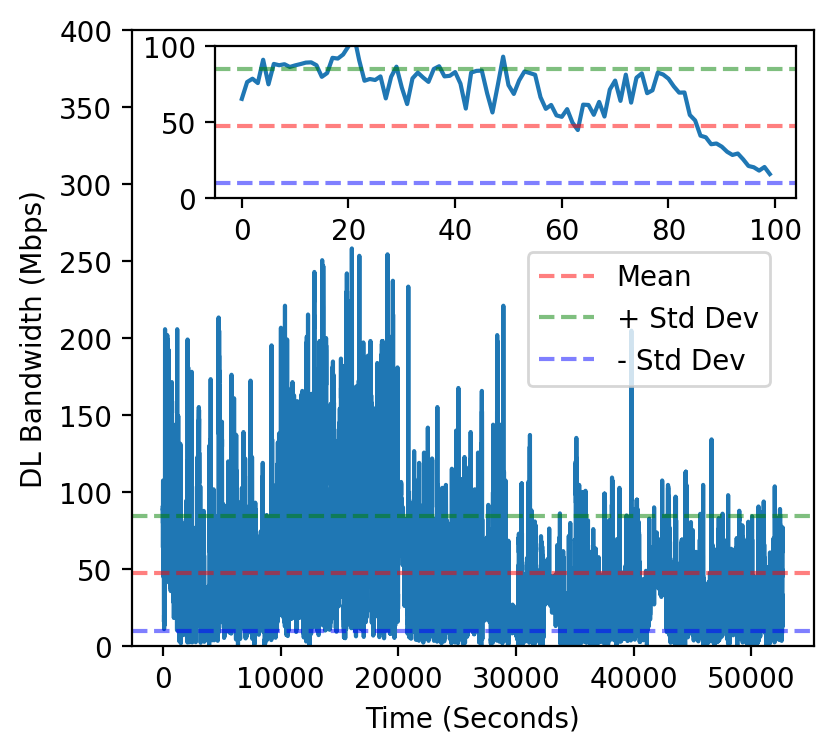

In [35]:
figure_size = (4.4, 4)
fig, ax1 = plt.subplots(figsize=figure_size, dpi=200)
ax1.set_xlabel('Time (Seconds)')
ax1.set_ylabel('DL Bandwidth (Mbps)')
ax1.set_ylim(bottom=0, top=400)

left, bottom, width, height = [0.22, 0.67, 0.66, 0.19]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_ylim(bottom=0, top=100)

ax1.plot(df_plot['datarate'].div(1024*1024))

alpha_val = 0.5
# Plot mean and standard deviation lines on ax1
ax1.axhline(mean_value, color='r', linestyle='--', alpha=alpha_val, label='Mean')
ax1.axhline(mean_value + std_value, color='g', linestyle='--', alpha=alpha_val, label='+ Std Dev')
ax1.axhline(mean_value - std_value, color='b', linestyle='--', alpha=alpha_val, label='- Std Dev')

# Add legend
ax1.legend(loc='lower left', bbox_to_anchor=(0.56, 0.4))

ax2.plot(df_plot['datarate'].div(1024*1024)[:100])
# Plot mean and standard deviation lines on ax2
ax2.axhline(mean_value, color='r', linestyle='--', alpha=alpha_val, label='Mean')
ax2.axhline(mean_value + std_value, color='g', linestyle='--', alpha=alpha_val, label='+ Std Dev')
ax2.axhline(mean_value - std_value, color='b', linestyle='--', alpha=alpha_val, label='- Std Dev')
fig.savefig(f'plots/BerlinV2X-data.pdf', bbox_inches='tight')

In [8]:
df_plot['datarate'].div(1024*1024).describe()

count    52673.000000
mean        47.458586
std         37.380467
min          0.000812
25%         21.171570
50%         37.193298
75%         60.844421
max        258.445740
Name: datarate, dtype: float64

In [9]:
concat_filtered_data_downlink.head()

,device,datarate,Latitude,Longitude,Altitude,speed_kmh,COG,Pos in Ref Round,PCell_RSRP_1,PCell_RSRP_2,PCell_RSRP_max,PCell_RSRQ_1,PCell_RSRQ_2,PCell_RSRQ_max,PCell_RSSI_1,PCell_RSSI_2,PCell_RSSI_max,PCell_SNR_1,PCell_SNR_2,PCell_E-ARFCN,PCell_Downlink_Num_RBs,PCell_Downlink_TB_Size,PCell_Downlink_RBs_MCS_0,PCell_Downlink_RBs_MCS_1,PCell_Downlink_RBs_MCS_2,PCell_Downlink_RBs_MCS_3,PCell_Downlink_RBs_MCS_4,PCell_Downlink_RBs_MCS_5,PCell_Downlink_RBs_MCS_6,PCell_Downlink_RBs_MCS_7,PCell_Downlink_RBs_MCS_8,PCell_Downlink_RBs_MCS_9,PCell_Downlink_RBs_MCS_10,PCell_Downlink_RBs_MCS_11,PCell_Downlink_RBs_MCS_12,PCell_Downlink_RBs_MCS_13,PCell_Downlink_RBs_MCS_14,PCell_Downlink_RBs_MCS_15,PCell_Downlink_RBs_MCS_16,PCell_Downlink_RBs_MCS_17,PCell_Downlink_RBs_MCS_18,PCell_Downlink_RBs_MCS_19,PCell_Downlink_RBs_MCS_20,PCell_Downlink_RBs_MCS_21,PCell_Downlink_RBs_MCS_22,PCell_Downlink_RBs_MCS_23,PCell_Downlink_RBs_MCS_24,PCell_Downlink_RBs_MCS_25,PCell_Downlink_RBs_MCS_26,PCell_Downlink_RBs_MCS_27,PCell_Downlink_RBs_MCS_28,PCell_Downlink_RBs_MCS_29,PCell_Downlink_RBs_MCS_30,PCell_Downlink_RBs_MCS_31,PCell_Downlink_Average_MCS,PCell_Uplink_Num_RBs,PCell_Uplink_TB_Size,PCell_Uplink_Tx_Power_(dBm),PCell_Cell_ID,PCell_Downlink_frequency,PCell_Uplink_frequency,PCell_Downlink_bandwidth_MHz,PCell_Uplink_bandwidth_MHz,PCell_Cell_Identity,PCell_TAC,PCell_Band_Indicator,PCell_freq_MHz,SCell_RSRP_1,SCell_RSRP_2,SCell_RSRP_max,SCell_RSRQ_1,SCell_RSRQ_2,SCell_RSRQ_max,SCell_RSSI_1,SCell_RSSI_2,SCell_RSSI_max,SCell_SNR_1,SCell_SNR_2,SCell_E-ARFCN,SCell_Downlink_Num_RBs,SCell_Downlink_TB_Size,SCell_Downlink_RBs_MCS_0,SCell_Downlink_RBs_MCS_1,SCell_Downlink_RBs_MCS_2,SCell_Downlink_RBs_MCS_3,SCell_Downlink_RBs_MCS_4,SCell_Downlink_RBs_MCS_5,SCell_Downlink_RBs_MCS_6,SCell_Downlink_RBs_MCS_7,SCell_Downlink_RBs_MCS_8,SCell_Downlink_RBs_MCS_9,SCell_Downlink_RBs_MCS_10,SCell_Downlink_RBs_MCS_11,SCell_Downlink_RBs_MCS_12,SCell_Downlink_RBs_MCS_13,SCell_Downlink_RBs_MCS_14,SCell_Downlink_RBs_MCS_15,SCell_Downlink_RBs_MCS_16,SCell_Downlink_RBs_MCS_17,SCell_Downlink_RBs_MCS_18,SCell_Downlink_RBs_MCS_19,SCell_Downlink_RBs_MCS_20,SCell_Downlink_RBs_MCS_21,SCell_Downlink_RBs_MCS_22,SCell_Downlink_RBs_MCS_23,SCell_Downlink_RBs_MCS_24,SCell_Downlink_RBs_MCS_25,SCell_Downlink_RBs_MCS_26,SCell_Downlink_RBs_MCS_27,SCell_Downlink_RBs_MCS_28,SCell_Downlink_RBs_MCS_29,SCell_Downlink_RBs_MCS_30,SCell_Downlink_RBs_MCS_31,SCell_Downlink_Average_MCS,SCell_Uplink_Num_RBs,SCell_Uplink_TB_Size,SCell_Uplink_Tx_Power_(dBm),SCell_Cell_ID,SCell_Downlink_frequency,SCell_Uplink_frequency,SCell_Downlink_bandwidth_MHz,SCell_Uplink_bandwidth_MHz,SCell_Cell_Identity,SCell_TAC,SCell_Band_Indicator,SCell_MCC,SCell_MNC_Digit,SCell_MNC,SCell_Allowed_Access,SCell_freq_MHz,operator
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-22 09:49:54+02:00,pc1,68700000.0,52.514013,13.335172,41.9,0.0,0.0,NaN,-76.638750,-79.811875,-76.638750,-14.459375,-14.248750,-14.119375,-42.186875,-45.562500,-45.562500,19.255,22.090,1300.0,29914.0,4381967.0,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,392.0,1475.0,2287.0,3245.5,1461.0,3801.0,6476.0,4757.5,4120.0,NaN,NaN,1803.0,26.0,429.0,2267.0,111.224691,246.0,1300.0,19300.0,20.0,20.0,33802242.0,1494.0,3.0,1800.0,-84.699375,-73.418750,-73.418750,-9.640625,-10.627500,-9.631250,-55.057500,-42.787500,-42.787500,21.968,26.189,3050.0,46392.0,6111069.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,376.0,3703.0,21673.0,13544.0,1524.0,3174.0,NaN,NaN,NaN,NaN,2398.0,24.0,NaN,NaN,NaN,431.0,3050.0,21050.0,20,20,33802248.0,1494.0,7.0,262.0,2.0,1.0,0.0,2600.0,1
2021-06-22 09:49:55+02:00,pc1,80300000.0,52.514012,13.335173,41.9,0.0,0.0,NaN,-77.602500,-79.874375,-77.602500,-15.041875,-14.629375,-14.550000,-42.562500,-45.241250,-45.241250,17.914,22.183,1300.0,36796.0,5085821.0,NaN,44.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,N

In [10]:
concat_filtered_data_downlink.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52673 entries, 2021-06-22 09:49:54+02:00 to 2021-06-24 18:52:46+02:00
Columns: 131 entries, device to operator
dtypes: float64(127), int64(1), object(3)
memory usage: 53.0+ MB


In [11]:
# Select features
filtered_data_downlink_selected = concat_filtered_data_downlink[[
    'datarate',
    'PCell_Downlink_TB_Size', 'SCell_Downlink_TB_Size', 
    'PCell_SNR_1', 'PCell_SNR_2', 'SCell_SNR_1', 'SCell_SNR_2', 
    'PCell_RSSI_1', 'PCell_RSSI_2', 'PCell_RSSI_max',  
    'PCell_RSRP_1', 'PCell_RSRP_2', 'PCell_RSRP_max',
    'PCell_Downlink_Average_MCS', 'SCell_Downlink_Average_MCS', 
    'PCell_Downlink_Num_RBs', 'SCell_Downlink_Num_RBs']]

filtered_data_downlink_selected.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52673 entries, 2021-06-22 09:49:54+02:00 to 2021-06-24 18:52:46+02:00
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   datarate                    52673 non-null  float64
 1   PCell_Downlink_TB_Size      52647 non-null  float64
 2   SCell_Downlink_TB_Size      27231 non-null  float64
 3   PCell_SNR_1                 52637 non-null  float64
 4   PCell_SNR_2                 52637 non-null  float64
 5   SCell_SNR_1                 28657 non-null  float64
 6   SCell_SNR_2                 28657 non-null  float64
 7   PCell_RSSI_1                52637 non-null  float64
 8   PCell_RSSI_2                52637 non-null  float64
 9   PCell_RSSI_max              52637 non-null  float64
 10  PCell_RSRP_1                52637 non-null  float64
 11  PCell_RSRP_2                52637 non-null  float64
 12  PCell_RSRP_max              52637 non-nul

In [12]:
filtered_data_downlink_selected['date'] = filtered_data_downlink_selected.index

/tmp/ipykernel_970320/3750080312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_downlink_selected['date'] = filtered_data_downlink_selected.index


In [13]:
filtered_data_downlink_selected.ffill(limit=5, inplace=True)
filtered_data_downlink_selected.fillna(0, inplace=True)
filtered_data_downlink_selected.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52673 entries, 2021-06-22 09:49:54+02:00 to 2021-06-24 18:52:46+02:00
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype                        
---  ------                      --------------  -----                        
 0   datarate                    52673 non-null  float64                      
 1   PCell_Downlink_TB_Size      52673 non-null  float64                      
 2   SCell_Downlink_TB_Size      52673 non-null  float64                      
 3   PCell_SNR_1                 52673 non-null  float64                      
 4   PCell_SNR_2                 52673 non-null  float64                      
 5   SCell_SNR_1                 52673 non-null  float64                      
 6   SCell_SNR_2                 52673 non-null  float64                      
 7   PCell_RSSI_1                52673 non-null  float64                      
 8   PCell_RSSI_2                52673 non-null  float

/tmp/ipykernel_970320/2017817406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_downlink_selected.ffill(limit=5, inplace=True)
/tmp/ipykernel_970320/2017817406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_downlink_selected.fillna(0, inplace=True)


In [14]:
filtered_data_downlink_selected.describe()

,datarate,PCell_Downlink_TB_Size,SCell_Downlink_TB_Size,PCell_SNR_1,PCell_SNR_2,SCell_SNR_1,SCell_SNR_2,PCell_RSSI_1,PCell_RSSI_2,PCell_RSSI_max,PCell_RSRP_1,PCell_RSRP_2,PCell_RSRP_max,PCell_Downlink_Average_MCS,SCell_Downlink_Average_MCS,PCell_Downlink_Num_RBs,SCell_Downlink_Num_RBs
count,5.267300e+04,5.267300e+04,5.267300e+04,52673.000000,52673.000000,52673.000000,52673.000000,52673.000000,52673.000000,52673.000000,52673.000000,52673.000000,52673.000000,52673.000000,52673.000000,52673.000000,52673.000000
mean,4.976393e+07,4.524627e+06,2.617516e+06,10.744335,9.072081,5.986271,5.508088,-56.041132,-60.308330,-60.308330,-89.687946,-94.608625,-88.819027,19.865225,9.900537,61590.498567,35126.498358
std,3.919626e+07,3.011763e+06,3.502870e+06,7.529651,8.938396,8.083984,8.363758,10.959077,15.602209,15.602209,11.737896,17.766489,11.905223,5.321538,9.807939,23607.251834,37313.230915
min,8.510000e+02,0.000000e+00,0.000000e+00,-15.603000,-16.289899,-17.950000,-18.250000,-92.683333,-96.388462,-96.388462,-174.689375,-175.605625,-175.605625,0.000000,0.000000,0.000000,0.000000
25%,2.220000e+07,2.405036e+06,0.000000e+00,5.446000,3.602000,0.000000,0.000000,-63.305000,-67.619375,-67.619375,-97.376250,-101.821875,-96.683750,16.000000,0.000000,42202.000000,0.000000
50%,3.900000e+07,3.824019e+06,1.022330e+06,10.949000,9.715842,1.845000,0.000000,-55.931875,-57.961250,-57.961250,-89.764375,-92.017500,-88.893125,20.000000,11.000000,54024.000000,32668.000000
75%,6.380000e+07,5.869808e+06,4.113265e+06,16.390000,15.810000,12.867000,12.918000,-48.853125,-49.593125,-49.593125,-82.306250,-83.096250,-81.147500,24.000000,19.000000,86657.000000,71072.000000
max,2.710000e+08,1.867910e+07,1.843587e+07,28.958000,28.564000,28.478000,28.404000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,31.000000,100580.000000,99516.000000


In [15]:
directory = 'preprocessed-data/BerlinV2X'
if not os.path.exists(directory):
    os.makedirs(directory)

filtered_data_downlink_selected.info(verbose=True, show_counts=True)
filtered_data_downlink_selected.to_csv('preprocessed-data/BerlinV2X/filtered_data_downlink.csv', encoding='utf-8', index=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52673 entries, 2021-06-22 09:49:54+02:00 to 2021-06-24 18:52:46+02:00
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype                        
---  ------                      --------------  -----                        
 0   datarate                    52673 non-null  float64                      
 1   PCell_Downlink_TB_Size      52673 non-null  float64                      
 2   SCell_Downlink_TB_Size      52673 non-null  float64                      
 3   PCell_SNR_1                 52673 non-null  float64                      
 4   PCell_SNR_2                 52673 non-null  float64                      
 5   SCell_SNR_1                 52673 non-null  float64                      
 6   SCell_SNR_2                 52673 non-null  float64                      
 7   PCell_RSSI_1                52673 non-null  float64                      
 8   PCell_RSSI_2                52673 non-null  float

In [16]:
#filtered_data_downlink_selected.head()

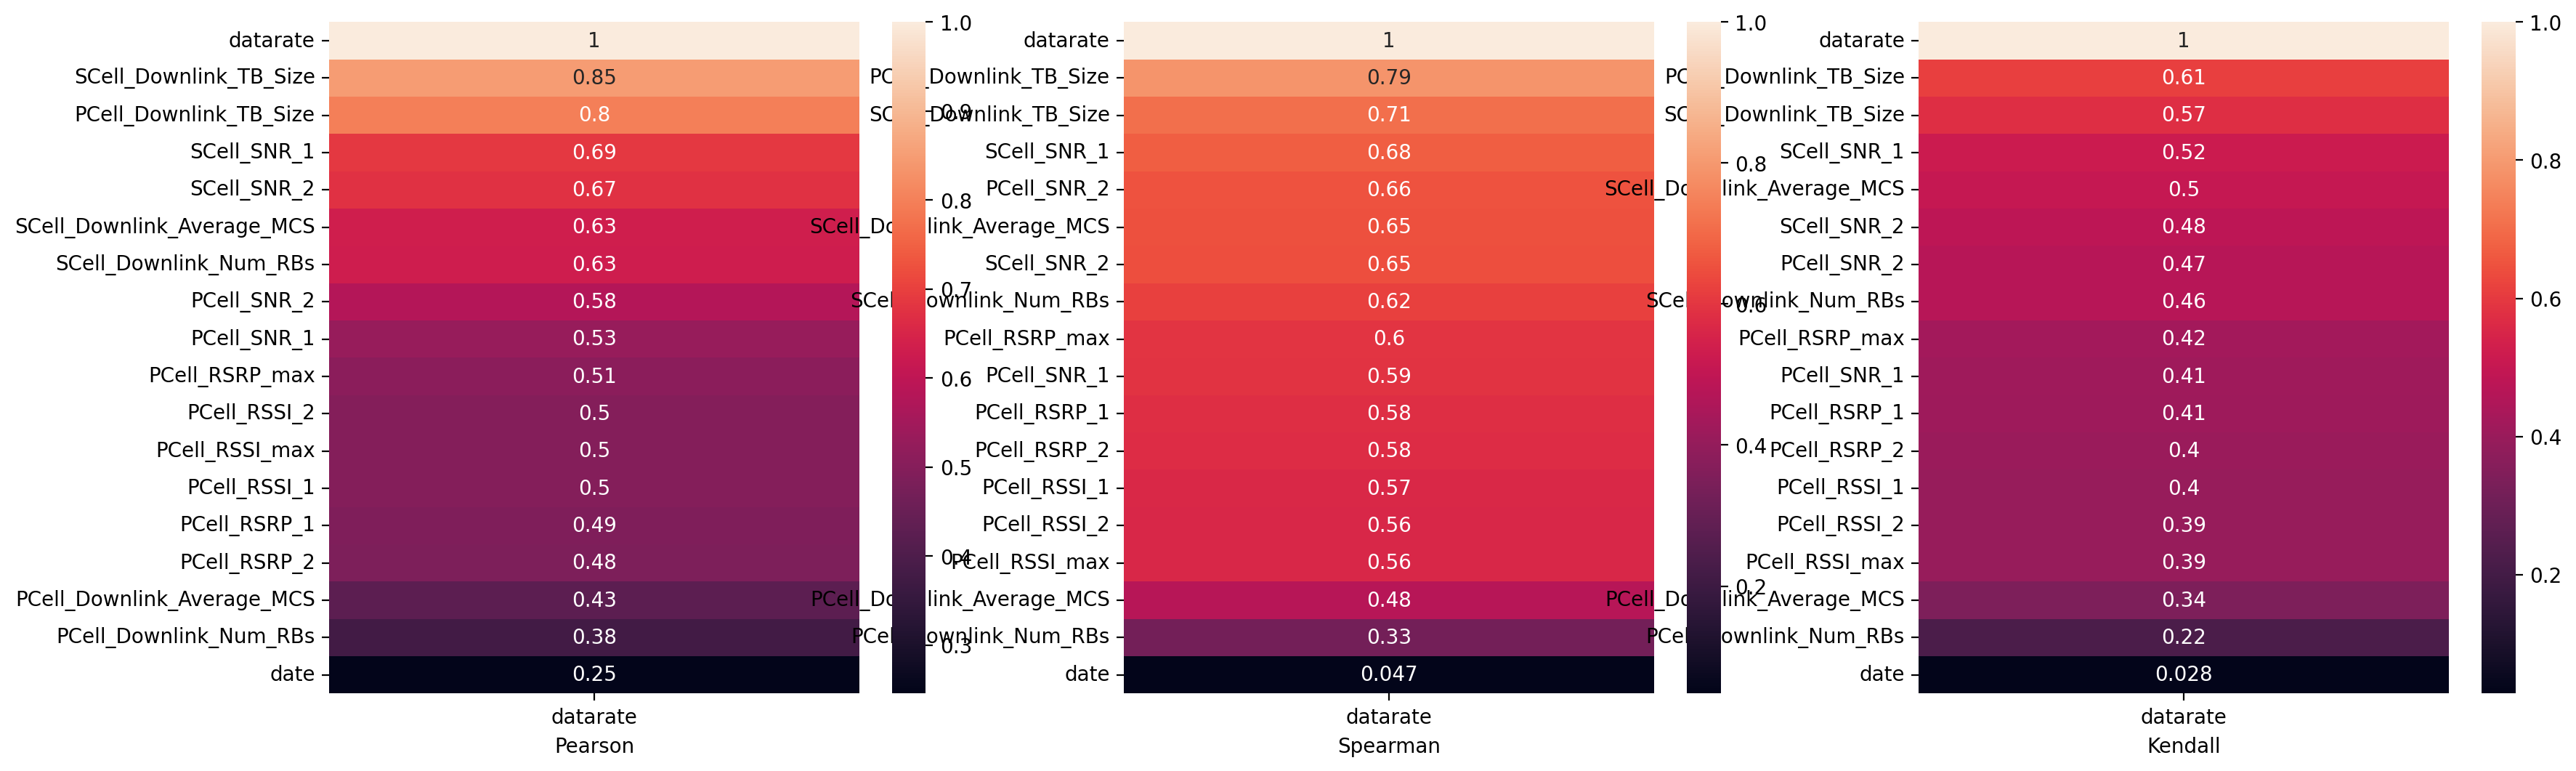

In [17]:
pearson, spearman, kendall = correlation.multi(filtered_data_downlink_selected, 'datarate')

In [18]:
df_corr = pearson
df_corr['pearson'] = pearson
df_corr['spearman'] = spearman
df_corr['kendall'] = kendall
df_corr.drop(columns=['datarate'], inplace=True)

df_corr['average'] = df_corr.mean(axis=1)
df_corr

,pearson,spearman,kendall,average
datarate,1.000000,1.000000,1.000000,1.000000
SCell_Downlink_TB_Size,0.847742,0.713194,0.573318,0.711418
PCell_Downlink_TB_Size,0.797109,0.791373,0.610053,0.732845
SCell_SNR_1,0.685647,0.678052,0.515107,0.626269
SCell_SNR_2,0.674484,0.646673,0.482764,0.601307
SCell_Downlink_Average_MCS,0.634042,0.651000,0.500547,0.595196
SCell_Downlink_Num_RBs,0.629578,0.623857,0.464920,0.572785
PCell_SNR_2,0.581212,0.655686,0.465526,0.567475
PCell_SNR_1,0.528634,0.590892,0.413328,0.510951
PCell_RSRP_max,0.508006,0.596185,0.422238,0.508809


In [19]:
# EWMA

# scope is duration of test dataset (%20 of whole data)
scope = int(len(filtered_data_downlink_selected) * 0.2) #10534
tail = filtered_data_downlink_selected.tail(scope)
tail = tail[['datarate']]

span = 8
pred_len = 1

ewma.predict_and_evaluate(tail, 'datarate', span, pred_len)

EWMA8 rmse: 8887482.695764722, mae: 6056226.595529158
Shifted rmse: 7556218.80730079, mae: 5022861.567695962


In [20]:
# ARIMA

# lenght of last %20 + window size
scope = 10534 + 32
df_arima = filtered_data_downlink_selected.tail(scope)
df_arima = df_arima[['datarate']]
df_arima.head()

,datarate
timestamp,
2021-06-22 16:41:48+02:00,59600000.0
2021-06-22 16:41:49+02:00,51900000.0
2021-06-22 16:41:50+02:00,39400000.0
2021-06-22 16:41:51+02:00,40600000.0
2021-06-22 16:41:52+02:00,39400000.0


In [ ]:
# Define the rolling window size and prediction horizon
window_size = 32
prediction_horizon = 1

# Predict the next value using ARIMA model with a rolling window
predictions = arima.predict_next_value(df_arima['datarate'], window_size=window_size, horizon=prediction_horizon)

arima.evaluate(predictions, df_arima, window_size, prediction_horizon)